<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/PowerGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Power Plant dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch > \dev\null # Suppress prints
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/power.ipynb" # Run the Power notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None

AT    False
V     False
AP    False
RH    False
PE    False
dtype: bool
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander
----------------------------------------------------------
ALL MODELS: 
KIS

# Prepare The Data

In [ ]:
powerPlant_data = df_PowerPlant # df_PowerPlant is defined in ../datasets/power.ipynb
# The last column is output(net hourly electrical energy output (EP)  of the plant)
x_power, y_power = powerPlant_data.iloc[:, :-1].to_numpy() , powerPlant_data.iloc[:, -1].to_numpy()


x_train_power, x_test_power, y_train_power, y_test_power = train_test_split(x_power, y_power, test_size=0.2, random_state=666)
# Transform into tensors
x_train_power, x_test_power, y_train_power, y_test_power = (
torch.from_numpy(x_train_power).float(), torch.from_numpy(x_test_power).float(),
torch.from_numpy(y_train_power).float(), torch.from_numpy(y_test_power).float())

# Standardized data
scaler = StandardScaler()
x_train_power_standardized = torch.from_numpy(scaler.fit_transform(x_train_power)).float()
# Use the same scaler that was used on training data
x_test_power_standardized = torch.from_numpy(scaler.transform(x_test_power)).float()

if torch.cuda.is_available():
    x_train_power, y_train_power, x_test_power, y_test_power, x_train_power_standardized, x_test_power_standardized = (
    x_train_power.cuda(), y_train_power.cuda(), x_test_power.cuda(), y_test_power.cuda(),
    x_train_power_standardized.cuda(), x_test_power_standardized.cuda())

# Train data into batches
train_dataset_power = TensorDataset(x_train_power, y_train_power)
train_loader_power = DataLoader(train_dataset_power, batch_size=500, shuffle=True)

# Test data into batches
test_dataset_power = TensorDataset(x_test_power, y_test_power)
test_loader_power = DataLoader(test_dataset_power, batch_size=500, shuffle=False)

# Standardized batches
# Train data into batches
train_dataset_power_standardized = TensorDataset(x_train_power_standardized, y_train_power)
train_loader_power_standardized = DataLoader(train_dataset_power_standardized, batch_size=500, shuffle=True)

# Test data into batches
test_dataset_power_standardized = TensorDataset(x_test_power_standardized, y_test_power)
test_loader_power_standardized = DataLoader(test_dataset_power_standardized, batch_size=500, shuffle=False)

# Define the KISS-GP Model

In [ ]:
KISSGP_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_power = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_power = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_power = KISSGP_NDim(x_train_power,
                                 y_train_power,
                                 KISSGP_likelihood_power,
                                 KISSGP_mean_power,
                                 KISSGP_kernel_power) # KISSGP defined in utils/Models.ipynb
KISSGP_model_power = KISSGP_model_power.to(device) # Move model to device.

# One with standardized features
KISSGP_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_power_standardized = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_power_standardized = KISSGP_NDim(x_train_power_standardized,
                                              y_train_power,
                                              KISSGP_likelihood_power_standardized,
                                              KISSGP_mean_power_standardized,
                                              KISSGP_kernel_power_standardized) # KISSGP defined in utils/Models.ipynb
KISSGP_model_power_standardized = KISSGP_model_power_standardized.to(device) # Move model to device.

# Train and Evaluate the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  res = cls(index_tensor, value_tensor, interp_size)
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=,

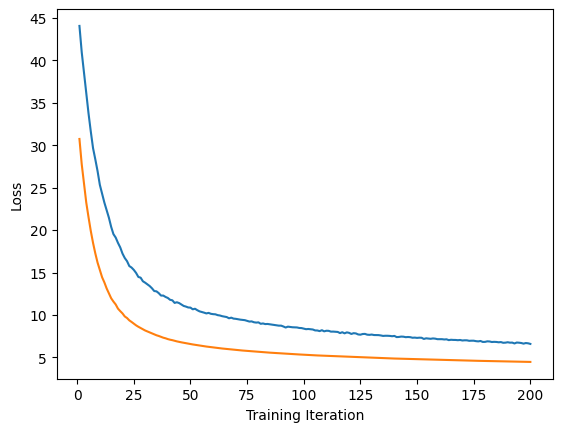

In [ ]:
train_time_KISSGP_power= train(KISSGP_model_power,
                          KISSGP_likelihood_power,
                          x_train_power,
                          y_train_power,
                          training_iter= 200) # train is defined in utils/functions.ipynb
# Standardized version
train_time_KISSGP_power_standardized = train(KISSGP_model_power_standardized,
                                       KISSGP_likelihood_power_standardized,
                                       x_train_power_standardized,
                                       y_train_power,
                                       training_iter= 200) # train is defined in utils/functions.ipynb

In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_power = predict(KISSGP_model_power, KISSGP_likelihood_power,
                                     x_test_power) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_power, NLPD_KISSGP_power, PICP_KISSGP_power, MPIW_KISSGP_power = error_metrics(
      x_test_power,
      y_test_power,
      predictions_KISSGP_power.mean,
      predictions_KISSGP_power.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_KISSGP_power_standardized = predict(KISSGP_model_power_standardized, KISSGP_likelihood_power_standardized,
                                                  x_test_power_standardized) # predict is defined in utils/functions.ipynb

  RMSE_KISSGP_power_standardized, NLPD_KISSGP_power_standardized, PICP_KISSGP_power_standardized, MPIW_KISSGP_power_standardized = error_metrics(
      x_test_power_standardized,
      y_test_power,
      predictions_KISSGP_power_standardized.mean,
      predictions_KISSGP_power_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_power)
  print("NLPD KISS-GP: ",NLPD_KISSGP_power)
  print("PICP KISS-GP: ",PICP_KISSGP_power)
  print("MPIW KISS-GP: ",MPIW_KISSGP_power)
  print("Time KISS-GP: ", KISSGP_power_time)

  print("RMSE KISS-GP Standardized: ",RMSE_KISSGP_power_standardized)
  print("NLPD KISS-GP Standardized: ",NLPD_KISSGP_power_standardized)
  print("PICP KISS-GP Standardized: ",PICP_KISSGP_power_standardized)
  print("MPIW KISS-GP Standardized: ",MPIW_KISSGP_power_standardized)
  print("Time KISS-GP Standardized: ", KISSGP_power_time_standardized)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 22.900772094726562 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


RMSE KISS-GP:  6.2412357
NLPD KISS-GP:  -1.432560920715332
CP KISS-GP:  0.5376175548589341
PIW KISS-GP:  9.379012
Time KISS-GP:  133.46149396896362
RMSE KISS-GP Standardized:  4.8579836
NLPD KISS-GP Standardized:  0.17040300369262695
CP KISS-GP Standardized:  0.6520376175548589
PIW KISS-GP Standardized:  9.064464
Time KISS-GP Standardized:  65.27640151977539


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8747243881225586 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


# Variational Distribution Model

In [ ]:
variational_likelihood_power = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_power = gpytorch.means.ConstantMean()
variational_kernel_power = gpytorch.kernels.RBFKernel()
n_inducing_points = 2000
# Generate a tensor of random indices
indices = torch.randperm(x_train_power.size(0))
# Select N random rows
inducing_points = x_train_power[indices][:n_inducing_points]
variational_model_power = variationalGP(variational_likelihood_power,
                                        variational_mean_power,
                                        variational_kernel_power,
                                        inducing_points) # InducingGP defined in utils/models.ipynb
variational_model_power = variational_model_power.to(device) # Move model to device, defined in utils/models.ipynb

# Standardized version
variational_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_power_standardized = gpytorch.means.ConstantMean()
variational_kernel_power_standardized = gpytorch.kernels.RBFKernel()
n_inducing_points = 4500
# Generate a tensor of random indices
indices = torch.randperm(x_train_power_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_power_standardized[indices][:n_inducing_points]
variational_model_power_standardized = variationalGP(variational_likelihood_power_standardized,
                                               variational_mean_power_standardized,
                                               variational_kernel_power_standardized,
                                               inducing_points_standardized) # InducingGP defined in utils/models.ipynb
variational_model_power_standardized = variational_model_power_standardized.to(device) # Move model to device, defined in utils/models.ipynb

# Train and Evaluate Variational Model

In [ ]:
# Use train_loader_power
train_time_variational_power = train_ELBO(variational_model_power,
                                 variational_likelihood_power,
                                 x_train_power,
                                 y_train_power,
                                 training_iter= 80,
                                 train_loader=train_loader_power) # train is defined in utils/functions.ipynb

# Standardized version, train_loader_power_standardized
train_time_variational_power_standardized = train_ELBO(variational_model_power_standardized,
                                              variational_likelihood_power_standardized,
                                              x_train_power_standardized,
                                              y_train_power,
                                              training_iter= 80,
                                              train_loader=train_loader_power_standardized) # train is defined in utils/functions.ipynb

In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_power = predict(variational_model_power, variational_likelihood_power, x_test_power)

  RMSE_variational_power, NLPD_variational_power, PICP_variational_power, MPIW_variational_power = error_metrics(
      x_test_power,
      y_test_power,
      predictions_variational_power.mean,
      predictions_variational_power.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_power)
  print("NLPD variational Model: ",NLPD_variational_power)
  print("PICP variational Model: ",PICP_variational_power)
  print("MPIW variational Model: ",MPIW_variational_power)
  print("Time variational Model: ", train_time_variational_power)

  # Standardized version
  predictions_variational_power_standardized = predict(variational_model_power_standardized,
                                       variational_likelihood_power_standardized,
                                       x_test_power_standardized)

  RMSE_variational_power_standardized, NLPD_variational_power_standardized, PICP_variational_power_standardized, MPIW_variational_power_standardized = error_metrics(
      x_test_power_standardized,
      y_test_power,
      predictions_variational_power_standardized.mean,
      predictions_variational_power_standardized.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model Standardized: ",RMSE_variational_power_standardized)
  print("NLPD variational Model Standardized: ",NLPD_variational_power_standardized)
  print("PICP variational Model Standardized: ",PICP_variational_power_standardized)
  print("MPIW variational Model Standardized: ",MPIW_variational_power_standardized)
  print("Time variational Model Standardized: ", train_time_variationalStandardized_power)

RMSE variational Model:  4.768341293443404
NLPD variational Model:  2.963347160299204
CP variational Model:  0.945141065830721
PIW variational Model:  18.6254638099254
Time variational Model:  363.7607378959656
RMSE variational Model Standardized:  4.893381993562672
NLPD variational Model Standardized:  4.333409220541801
CP variational Model Standardized:  0.7366771159874608
PIW variational Model Standardized:  10.542493935564131
Time variational Model Standardized:  357.81378507614136


# Inducing Points Model

In [ ]:
inducing_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_power = gpytorch.means.ConstantMean() # Mean
inducing_kernel_power = gpytorch.kernels.RBFKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(x_train_power.size(0))
# Select N random rows
inducing_points_amount = 4500 # Around half of the points
inducing_points = x_train_power[indices][:n_inducing_points]
inducing_model_power = inducingGP(x_train_power,
                                 y_train_power,
                                 inducing_likelihood_power,
                                 inducing_mean_power,
                                 inducing_kernel_power,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

inducing_model_power = inducing_model_power.to(device) # Move model to device.

# One with standardized features
inducing_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
inducing_kernel_power_standardized = gpytorch.kernels.RBFKernel() # Kernel
# Generate a tensor of random indices
indices = torch.randperm(x_train_power_standardized.size(0))
# Select N random rows
inducing_points_standardized = x_train_power_standardized[indices][:inducing_points_amount]
inducing_model_power_standardized = inducingGP(x_train_power_standardized,
                                              y_train_power,
                                              inducing_likelihood_power_standardized,
                                              inducing_mean_power_standardized,
                                              inducing_kernel_power_standardized,
                                              inducing_points_standardized) # inducingGP defined in utils/Models.ipynb

inducing_model_power_standardized = inducing_model_power_standardized.to(device) # Move model to device.

# Train and evaluate the inducing model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


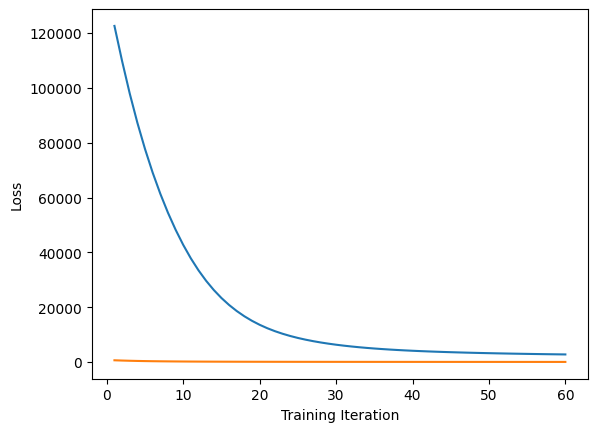

In [ ]:
train_time_inducing_power = train(inducing_model_power,
                          inducing_likelihood_power,
                          x_train_power,
                          y_train_power,
                          training_iter= 60) # train is defined in utils/functions.ipynb
# Standardized version
train_time_inducing_power_standardized = train(inducing_model_power_standardized,
                                       inducing_likelihood_power_standardized,
                                       x_train_power_standardized,
                                       y_train_power,
                                       training_iter= 60) # train is defined in utils/functions.ipynb

In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_power = predict(inducing_model_power, inducing_likelihood_power,
                                     x_test_power) # predict is defined in utils/functions.ipynb
  RMSE_inducing_power, NLPD_inducing_power, PICP_inducing_power, MPIW_inducing_power = error_metrics(
      x_test_power,
      y_test_power,
      predictions_inducing_power.mean,
      predictions_inducing_power.variance)# error_metrics defined in utils/functions.ipynb


  # Standardized version
  predictions_inducing_power_standardized = predict(inducing_model_power_standardized, inducing_likelihood_power_standardized,
                                                  x_test_power_standardized) # predict is defined in utils/functions.ipynb

  RMSE_inducing_power_standardized, NLPD_inducing_power_standardized, PICP_inducing_power_standardized, MPIW_inducing_power_standardized = error_metrics(
      x_test_power_standardized,
      y_test_power,
      predictions_inducing_power_standardized.mean,
      predictions_inducing_power_standardized.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE inducing: ",RMSE_inducing_power)
  print("NLPD inducing: ",NLPD_inducing_power)
  print("PICP inducing: ",PICP_inducing_power)
  print("MPIW inducing: ",MPIW_inducing_power)
  print("Time inducing: ", inducing_power_time)

  print("RMSE inducing Standardized: ",RMSE_inducing_power_standardized)
  print("NLPD inducing Standardized: ",NLPD_inducing_power_standardized)
  print("PICP inducing Standardized: ",PICP_inducing_power_standardized)
  print("MPIW inducing Standardized: ",MPIW_inducing_power_standardized)
  print("Time inducing Standardized: ", inducing_power_time_standardized)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


RMSE inducing:  65.893524
NLPD inducing:  649.1004638671875
PICP inducing:  0.14420062695924765
MPIW inducing:  6.190756
Time inducing:  2.6810450553894043
RMSE inducing Standardized:  7.967873
NLPD inducing Standardized:  10.680045127868652
PICP inducing Standardized:  0.45193312434691746
MPIW inducing Standardized:  7.034152
Time inducing Standardized:  66.6185405254364


# Display Results

In [ ]:
# Training times
models = ["KISS-GP", "Variational", "Inducing"]
times_power = [train_time_KISSGP_power_standardized, train_time_variational_power_standardized, train_time_inducing_power_standardized]
plot_bar(models, times_power, "Training Time on Power Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

In [ ]:
# RMSE
models = ["KISS-GP", "Variational", "Inducing"]
RMSE_power = [RMSE_KISSGP_power_standardized, RMSE_variational_power_standardized, RMSE_inducing_power_standardized]
plot_bar(models, RMSE_power, "RMSE on Power Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

In [ ]:
# NLPD
models = ["KISS-GP", "Variational", "Inducing"]
NLPD_power = [NLPD_KISSGP_power_standardized, NLPD_variational_power_standardized, NLPD_inducing_power_standardized]
plot_bar(models, NLPD_power, "NLPD on Power Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

In [ ]:
# PICP
models = ["KISS-GP", "Variational", "Inducing"]
PICP_power = [PICP_KISSGP_power_standardized, PICP_variational_power_standardized, PICP_inducing_power_standardized]
plot_bar(models, PICP_power, "PICP on Power Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

In [ ]:
# MPIW
models = ["KISS-GP", "Variational", "Inducing"]
MPIW_power = [MPIW_KISSGP_power_standardized, MPIW_variational_power_standardized, MPIW_inducing_power_standardized]
plot_bar(models, MPIW_power, "MPIW on Power Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

In [ ]:
# Create table to summarize the best models
values_best = [
    times_power,
    RMSE_power,
    NLPD_power,
    PICP_power,
    MPIW_power
]

# Start the tabular environment
latex_table = "\\begin{tabular}{" + "c" * (len(models_compare) + 1) + "}\n"

# Add the model names to the table
latex_table += " & " + " & ".join(models_compare) + " \\\\\n\\hline\n"

# Add the values to the table
for i in range(len(values_compare)):
    latex_table += "Array" + str(i+1) + " & " + " & ".join(map(str, values_compare[i])) + " \\\\\n"

# End the tabular environment
latex_table += "\\end{tabular}"

print(latex_table)

In [ ]:
# Standardized or not?
# Training Time
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S"]
time_compare = [train_time_KISSGP_power, train_time_KISSGP_power_standardized,
                train_time_variational_power, train_time_variational_power_standardized,
                train_time_inducing_power, train_time_inducing_power_standardized]
plot_bar(models_compare, time_compare, "Training Time on Power Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

In [ ]:
# Standardized or not?
# RMSE
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S"]
RMSE_compare = [RMSE_KISSGP_power, RMSE_KISSGP_power_standardized,
                RMSE_variational_power, RMSE_variational_power_standardized,
                RMSE_inducing_power, RMSE_inducing_power_standardized]
plot_bar(models_compare, RMSE_compare, "RMSE on Power Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

In [ ]:
# Standardized or not?
# NLPD
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S"]
NLPD_compare = [NLPD_KISSGP_power, NLPD_KISSGP_power_standardized,
                NLPD_variational_power, NLPD_variational_power_standardized,
                NLPD_inducing_power, NLPD_inducing_power_standardized]
plot_bar(models_compare, NLPD_compare, "NLPD on Power Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

In [ ]:
# Standardized or not?
# PICP
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S"]
PICP_compare = [PICP_KISSGP_power, PICP_KISSGP_power_standardized,
                PICP_variational_power, PICP_variational_power_standardized,
                PICP_inducing_power, PICP_inducing_power_standardized]
plot_bar(models_compare, PICP_compare, "PICP on Power Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

In [ ]:
# Standardized or not?
# MPIW
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S"]
MPIW_compare = [MPIW_KISSGP_power, MPIW_KISSGP_power_standardized,
                MPIW_variational_power, MPIW_variational_power_standardized,
                MPIW_inducing_power, MPIW_inducing_power_standardized]
plot_bar(models_compare, MPIW_compare, "MPIW on Power Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

In [ ]:
# Create table to summarize differences between standardized and not, in Latex

values_compare = [
    time_compare,
    RMSE_compare,
    NLPD_compare,
    PICP_compare,
    MPIW_compare
]

# Start the tabular environment
latex_table = "\\begin{tabular}{" + "c" * (len(models_compare) + 1) + "}\n"

# Add the model names to the table
latex_table += " & " + " & ".join(models_compare) + " \\\\\n\\hline\n"

# Add the values to the table
for i in range(len(values_compare)):
    latex_table += "Array" + str(i+1) + " & " + " & ".join(map(str, values_compare[i])) + " \\\\\n"

# End the tabular environment
latex_table += "\\end{tabular}"

print(latex_table)
